# Support Vector Machine Classifier (Electrofacies).

* **Autor:** Rodrigo Lopez Aburto
* **Versión:** 1.0
* **Fecha:** Junio 2023

### Resumen

A lo largo de este cuaderno se sigue la metodología de construcción de un clasificador empleando el algoritmo de Support Vector Machine obtenido de la biblioteca de SciKit Learn. Se utilizaron datos de registros geofísicos junto con la clasificacion de **SOM** obtenida de núcleos para el ejercicio. La metodología, de manera breve sigue el proceso de carga de los datos, el conteo de las clases, la estandarización de los datos empleando el algoritmo de "StandardScaler" perteneciente a la biblioteca de SciKit Learn y por último la implementación del modelo de clasificación. Al final se muestran las métricas de la clasificación, así como la matriz de confusión obtenida.

**Carga de las bibliotecas**

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import cross_val_score

**Carga de las bibliotecas externas.**

In [2]:
from Funciones.GraphStatEng import *

**Carga de los datos**

Se cargo un archivo de datos que contenía información de registros geofísicos de pozo, petrofísica y propiedades elásticas, así como la clasificación geológica obtenida de los núcleos. Se decidió emplear un DataFrame para almacenar los datos del archivo original por su capacidad para facilitar el trabajar con tablas. Posteriormente a la carga de los datos se visualizó el DataFrame para confirmar que se cargó correctamente. Se colocó también bloque para el conteo de los datos, tanto filas como columnas del DataFrame.

El archivo de datos que se cargó contiene información de todos los pozos en la zona de estudio (20 pozos) cortados para contener registros únicamente de la formación Chicontepec Canal. Esto se decidió tomando como criterio el hecho de que la mayoría de los datos de núcleos pertenecían a este intervalo. En la variable identificada como "registros_cargados" se listan los mnemónicos que se usaran durante el análisis.

In [3]:
registros_cargados = ['DEPT','ECGR','RHOZ','DTCO','NPHI','SOM_4_Classes']

In [4]:
currdir = os.getcwd()
df_original = pd.read_csv(currdir + '\\Datos\\Electrofacies_SOM.csv', 
                            usecols=registros_cargados, low_memory=False, na_values=-999.25)
df_original.head(5)

,DEPT,ECGR,RHOZ,DTCO,NPHI,SOM_4_Classes
0,1126.0836,107.9460,2.3803,110.1317,0.3453,NaN
1,1126.2360,105.3806,2.3843,108.8417,0.3369,3.0
2,1126.3884,92.6494,2.4006,106.4857,0.3735,NaN
3,1126.5408,85.2163,2.4185,105.1499,0.3418,NaN
4,1126.6932,80.9719,2.4253,104.4066,0.3387,NaN


In [5]:
df_original_etiquetado = df_original.copy()
df_original_etiquetado.dropna(axis=0, inplace=True)

De manera precautoria se revisó que el DataFrame no contuviese datos nulos. Cabe resaltar que las etiquetas contendrán valores nulos considerando que no todo el intervalo de Chicontepec Canal contaba con etiquetas.

In [6]:
print(df_original.isnull().sum())

DEPT                 0
ECGR                 0
RHOZ                 0
DTCO                 0
NPHI                 0
SOM_4_Classes    56428
dtype: int64


### Normalización de los datos.

Buscando eliminar la dependencia de las variables predictoras a las unidades de las mismas, se realizó un proceso de estandarización previo a la separación del set de datos en entrenamiento y validación. Se cuenta con la posibilidad de usar escalamiento MinMax también, sin embargo, para este caso se utilizó estandarización. Posterior a este proceso se muestran los histogramas de cada uno de los registros para corroborar su transformación y las respectivas escalas de cada uno.

La estandarización se realizó empleando una funcionalidad de la biblioteca de SciKit Learn. Esta función recibe los datos que serán transformados únicamente por lo que para los valores de entrada no se seleccionó la columna de "Asociacion de facies 5to orden" debido a que se trata de una variable categórica.

El proceso de estandarización sigue una operación en la que a los datos se les sustrae el valor de la media y se les divide usando el valor de la desviación estándar. Considerando que el proceso emplea la media y desviación estándar de los datos que se le proporcionan, se decidió realizar la estandarización antes de preparar los datos y separarlos en sets de entrenamiento y validación.

Cabe destacar que el escalador se instancio usando el DataFrame original, es decir, la información de todos los pozos en el intervalo de Chicontepec canal. Esto se hizo debido a que se considera que la estadística que el estandazrizador debe extraer debe ser la de la población completa.

In [7]:
registros = list(df_original.columns)
registros.remove('DEPT')
registros.remove('SOM_4_Classes')

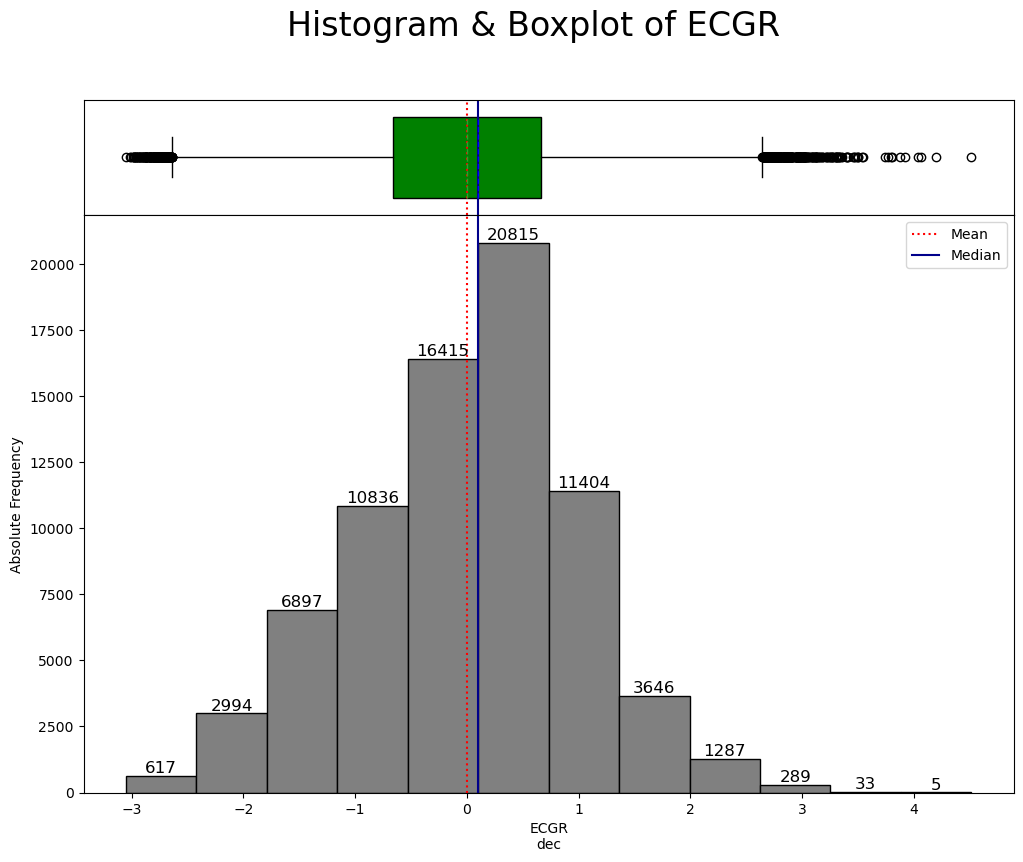

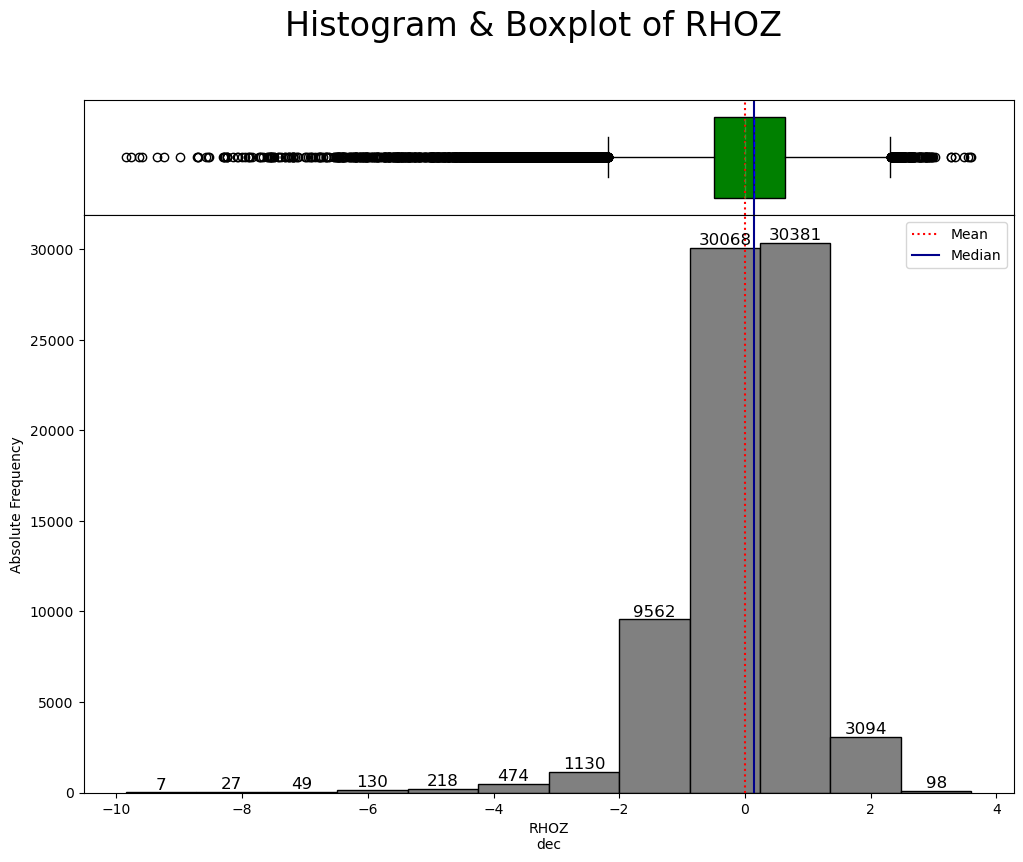

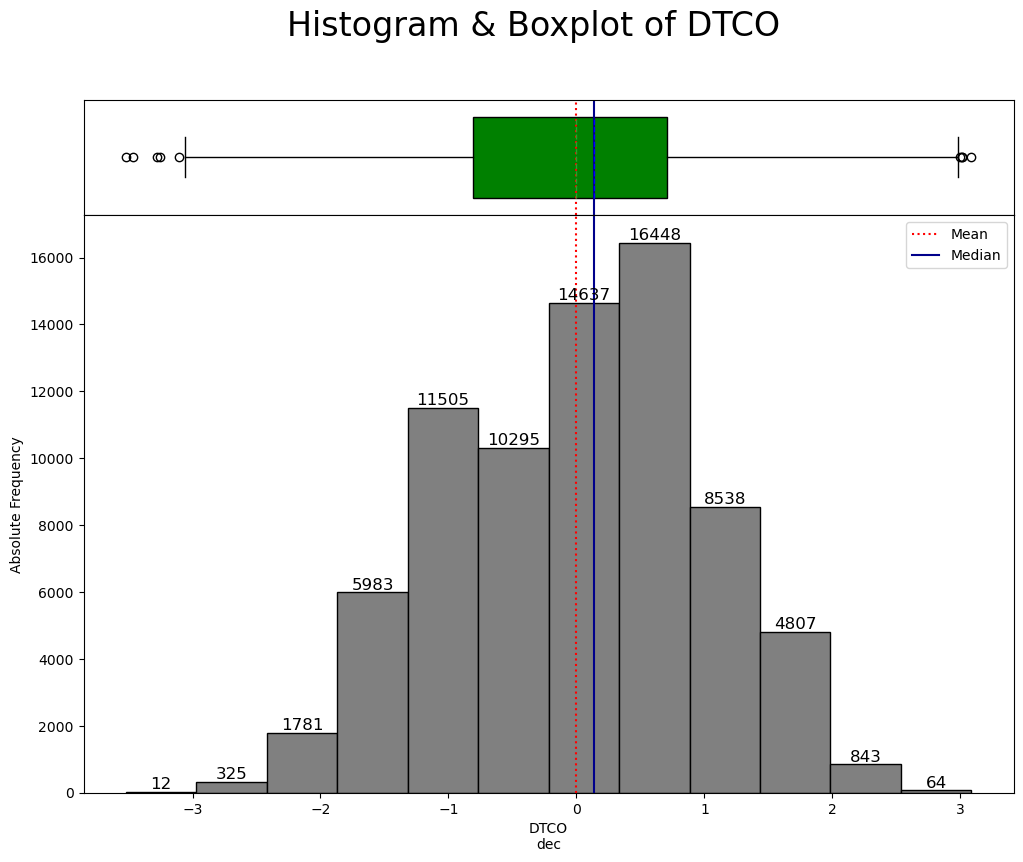

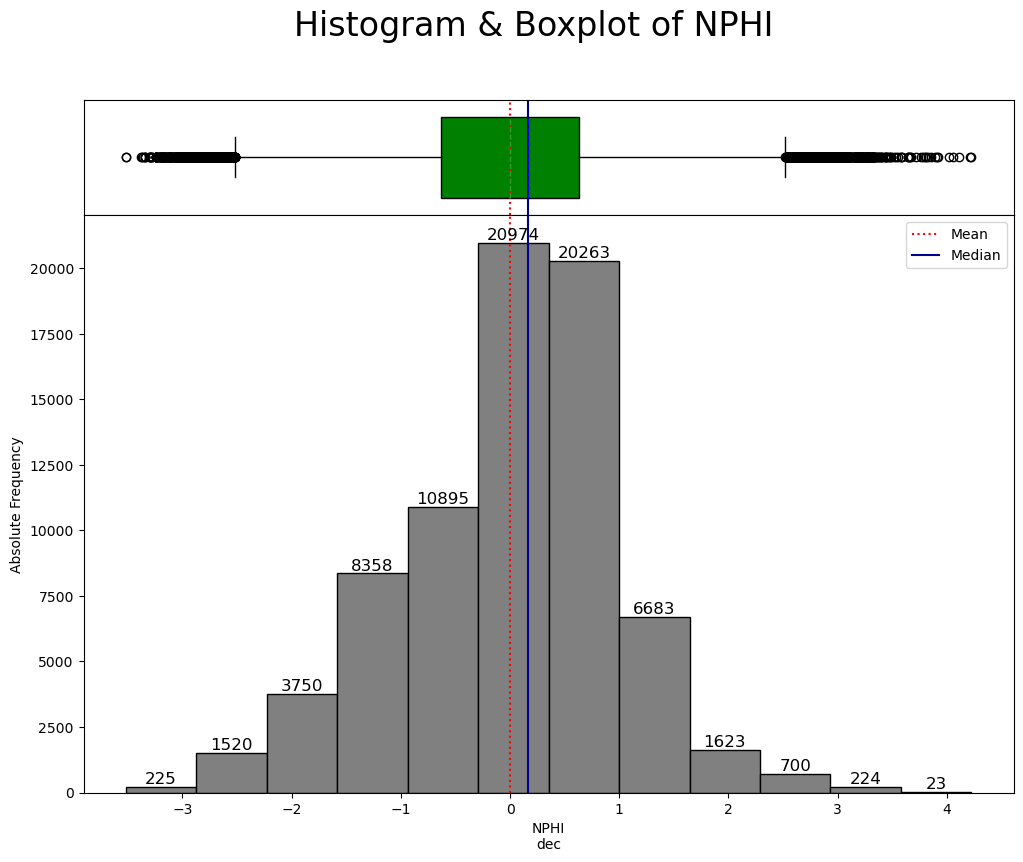

In [8]:
scaler = StandardScaler()
df_original_Standard = scaler.fit_transform(df_original[registros]) 
df_standard = pd.DataFrame(df_original_Standard, columns=registros)
for registro in registros:
    fig, axs = Plot_Hist(df_standard[registro], 12, 'dec', 12);
#    fig.savefig(currdir + '\Resultados\\Histograma_%s_std.png' % registro,
#                format="png", bbox_inches="tight", facecolor='white', dpi=300);

Considerando que el proceso de estandarización requirió la remoción temporal de las etiquetas de los datos se procedió a reconstruir el DataFrame original usando los datos escalados. Este nuevo DataFrame se nombró "df_normalizado".

In [9]:
df_normalizado = pd.concat([df_standard,df_original['SOM_4_Classes']], axis=1)
df_normalizado.head(5)

,ECGR,RHOZ,DTCO,NPHI,SOM_4_Classes
0,3.133146,-2.418532,2.522527,1.706753,NaN
1,2.964618,-2.358864,2.401562,1.571801,3.0
2,2.128271,-2.115717,2.180637,2.159805,NaN
3,1.639970,-1.848703,2.055378,1.650523,NaN
4,1.361144,-1.747267,1.985678,1.600719,NaN


Se creo un DataFrame llamado "df_normalizado_etiquetado" donde se extrajeron unicamente las filas con etiquetas para el proceso de analisis, entrenamiento y validacion del clasificador.

In [10]:
df_normalizado_etiquetado = df_normalizado.copy()
df_normalizado_etiquetado.dropna(axis=0, inplace=True)

### Preparación de los datos.

Se consideraron varios escenarios para el proceso de clasificacion, principalmente varias aproximaciones a la implementacion del algoritmo en funcion de los datos de entrada. Con esto en mente se prepararon varios sets de datos buscando el que produjese el mejor resultado. Para esto, los casos explorados fueron:

* Clasificacion con los registros geofisicos de pozo estandarizados solamente. **(df_normalizado)**

* Clasificacion con las componentes principales obtenidas a partir de los registros estandarizados. **(df_pca)**


### Implementación del Analísis de Componenetes Principales (PCA).

Buscando mejorar el desempeño del clasificador se decidió implementar un análisis PCA. Considerando que se contaba con 5 registros se exploró la posibilidad de reducir la dimensionalidad de los datos usando ya sea 2 o 3 componentes. Este número se determinó luego de analizar el porcentaje de la varianza explicado por estas componentes el cual se presenta en las gráficas debajo de la tabla donde se presentan los valores de la varianza explicados por cada componente.

El proceso de transformación de los datos se realizó empleando la función "pcamodel" perteneciente a la biblioteca de SciKit Learn. Esta función recibe el número de componentes en las que se transformaran los datos para posteriormente ajustar los mismos. La función recibe únicamente los valores que serán transformados, por lo que solo los registros fueron transformados. Se añadió un valor de "random_state" por propósitos de reproducibilidad de las componentes obtenidas para distintas implementaciones.

Al final del procedimiento se muestra una grafica de dispersion construida a partir de las componentes principales. Los puntos se encuentran coloreados en funcion de la etiqueta

In [11]:
pcamodel = PCA(n_components=3, random_state=0)
pca = pcamodel.fit_transform(df_normalizado_etiquetado[registros])
Tabla_PCA(pcamodel)

,Principal_Component,Explained Variance,Explained Variance Ratio
0,PC 1,2.930272,0.725398
1,PC 2,0.663843,0.164336
2,PC 3,0.296310,0.073353


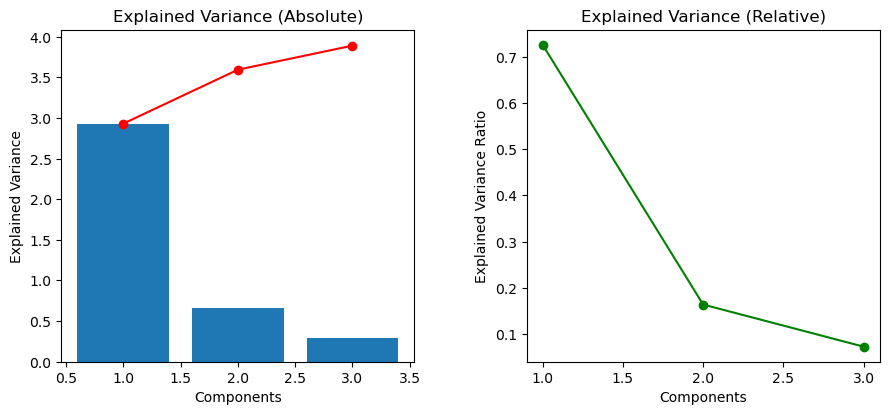

In [12]:
Graficar_varianza_PCA(pcamodel); plt.show()

De manera similar al caso de los registros normalizados se creo un DataFrame para almacenar las componentes principales y las clases en un solo lugar.

In [13]:
df_new = pd.DataFrame(data=pca, columns=['PC' + str(i) for i in range(1,3 + 1)])
df_pca = pd.concat([df_new,df_normalizado_etiquetado['SOM_4_Classes'].reset_index(drop=True)], axis=1)
df_pca.head(5)

,PC1,PC2,PC3,SOM_4_Classes
0,4.597633,0.001186,1.174830,3.0
1,3.677748,-0.235394,0.820157,3.0
2,3.090030,-0.066756,0.411529,3.0
3,3.359923,-0.054321,0.203119,3.0
4,3.779472,-0.176149,0.396473,3.0


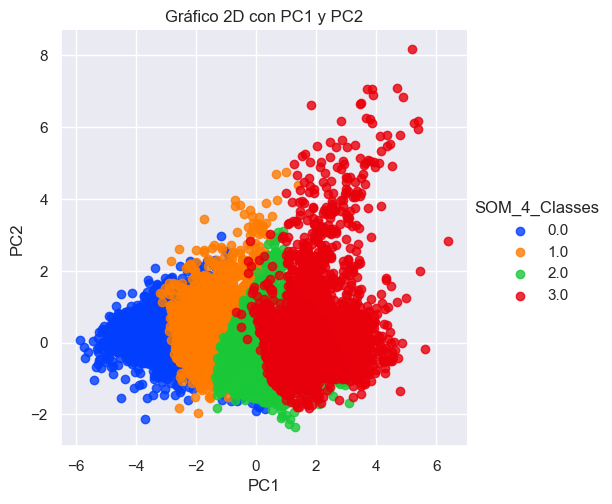

In [14]:
sns.set()
sns.lmplot(x='PC1', y='PC2', data=df_pca,
           fit_reg=False, legend=True, hue='SOM_4_Classes', palette='bright')
plt.title('Gráfico 2D con PC1 y PC2'); plt.show()

### Selección de Variables.

Buscando identificar las variables que más contribuyesen a la clasificación se realizó un proceso de estimación de la importancia de las variables para la clasificación geológica usando dos criterios. se decidió utilizar el criterio del método ANOVA y el criterio del método de Mutual Informacion. Los resultados se presentan en un gráfico de barras para comparar el valor de las diferentes variables con ambos criterios.

**ANOVA/F-Test**

In [15]:
f_statistic_completo, p_values = f_classif(df_original_etiquetado[registros],
                                           df_original_etiquetado['SOM_4_Classes'])
d = {'label': df_original[registros].columns, 'f_statistic': f_statistic_completo}
f_df = pd.DataFrame(data=d)
f_sorted = f_df.sort_values(by=['f_statistic'], ascending=False)
f_sorted;

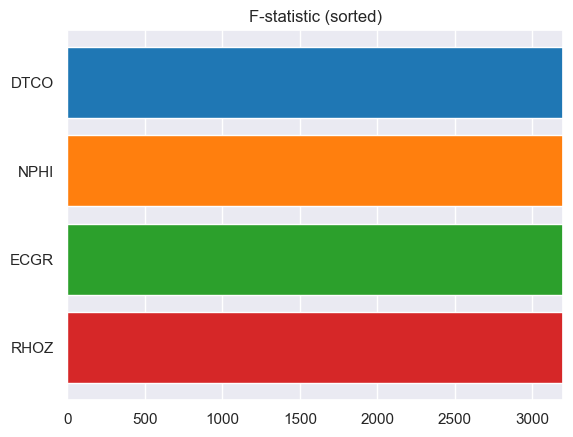

In [16]:
fig, ax = plt.subplots()
#class_plot = ax.barh(df_recortado[registros].columns, f_statistic, color=mcolors.TABLEAU_COLORS)
class_plot = ax.barh(f_sorted['label'], f_sorted['f_statistic'], color=mcolors.TABLEAU_COLORS)

ax.set_title('F-statistic (sorted)')
ax.bar_label(class_plot, fmt='%.1f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=3200)
plt.show()

**Mutual Information**

In [17]:
mi = mutual_info_classif(df_original_etiquetado[registros], df_original_etiquetado['SOM_4_Classes'])
d = {'label': df_original[registros].columns, 'mi': mi}
mi_df = pd.DataFrame(data=d)
mi_sorted = mi_df.sort_values(by=['mi'], ascending=False)
mi_sorted;

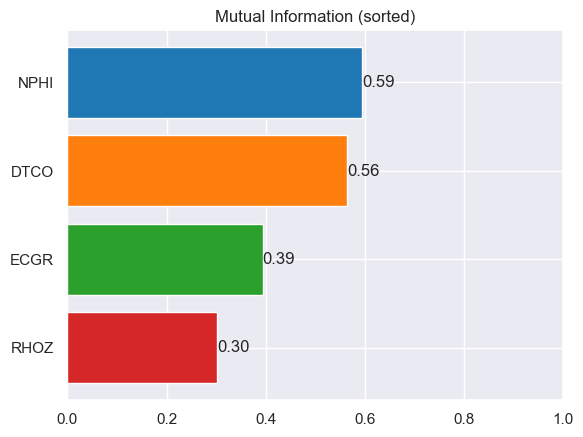

In [18]:
fig, ax = plt.subplots()
class_plot = ax.barh(mi_sorted['label'], mi_sorted['mi'], color=mcolors.TABLEAU_COLORS)
ax.set_title('Mutual Information (sorted)')
ax.bar_label(class_plot, fmt='%.2f', label_type='edge')
ax.invert_yaxis()
ax.set_xlim(right=1)
plt.show()

### Dendrograma.

Buscando comprender mejor la forma en la que las clases se van construyendo, se graficó un dendrograma con el objetivo de analizar la manera en la que agrupan los datos. Para esto se utilizó una funcionalidad de la biblioteca de Scipy llamada "dendrogram". La ejecución de esta función requiere dos pasos. Un primer paso donde se estiman las distancias entre los diferentes puntos de los datos con respecto a los clústeres hipotéticos. Esto se realizó tomando la distancia euclidiana y el método se seleccionó como "Warp".

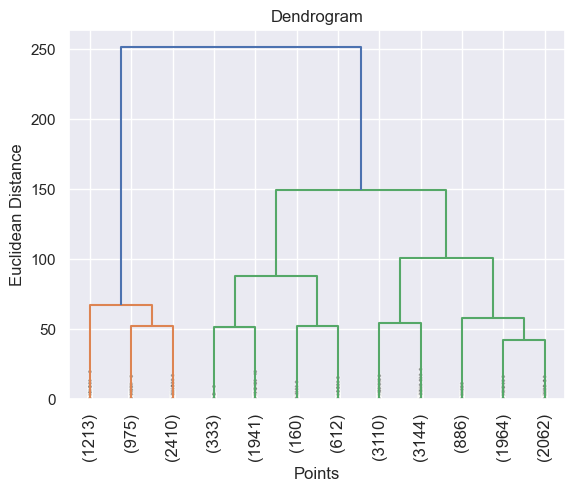

In [19]:
Dendro = linkage(df_normalizado_etiquetado[registros], metric='euclidean', method='ward')
plt.title('Dendrogram'); plt.xlabel('Points'); plt.ylabel('Euclidean Distance')
dendrogram(Dendro, truncate_mode='lastp', p=12, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.show()

### Visualización de las clases.

Considerando que durante el análisis exploratorio de datos se observó un cierto desbalance en las clases, se procedió a confirmar esto, buscando que la separación del set de datos respetase estas proporciones. Para este propósito primero se grafica un conteo de las clases de los datos originales y posteriormente se grafica el conteo correspondiente a las clases en los sets de datos de entrenamiento y prueba.

In [20]:
df_Categories_original = Contar_Clases(df_original_etiquetado, 'SOM_4_Classes')
df_Categories_original

,SOM_4_Classes,COUNT,PERCENT
0,0.0,2282,12.131845
1,1.0,4607,24.492291
2,2.0,6769,35.986178
3,3.0,5152,27.389686


### Creación del set de entrenamiento.

Buscando implementar el modelo clasificador y a la vez evaluar su desempeño, todo usando el mismo set de datos, se procedió a dividir el set en un set de datos de entrenamiento con el 70% de los datos y un set de datos de validación con el 30% restante de los datos. Para este propósito se utilizó una función perteneciente a la biblioteca de SciKit Learn llamada "TrainTestSplit".

Esta función requiere que se separe el set de datos original en un set de datos correspondiente a las variables predictoras, los registros geofísicos de pozo en este caso y un vector con las etiquetas. La función recibe ambas partes del set de datos y luego de proporcionársele una proporción (train_size) y una semilla aleatoria (random_state), la función toma pares de variables predictoras y etiquetas de manera aleatoria hasta completar la proporción indicada.

Considerando que se tienen varias opciones para entrenar y clasificar, este mismo proceso se realizó tanto en los datos de los registros estandarizados solamente como con las componentes principales.

**Para los registros estandarizados**

In [21]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(
    df_normalizado_etiquetado[registros],
    df_normalizado_etiquetado['SOM_4_Classes'], train_size=0.7, random_state=5)

**Para las componentes principales**

In [22]:
X_Train_pca, X_Test_pca, Y_Train_pca, Y_Test_pca = train_test_split(
    df_pca[['PC1','PC2','PC3']],
    df_pca['SOM_4_Classes'], train_size=0.7, random_state=0)

**Visualización del set de entrenamiento**

Se realizo el conteo de las clases y su visualización de manera grafica para confirmar que el set de datos conserva las mismas proporciones que el set de datos original.

In [23]:
df_Categories_Train = Contar_Clases(Y_Train, 'SOM_4_Classes')
df_Categories_Train

,SOM_4_Classes,COUNT,PERCENT
0,0.0,1563,11.870586
1,1.0,3233,24.553809
2,2.0,4790,36.378826
3,3.0,3581,27.196780


In [24]:
df_Categories_Test = Contar_Clases(Y_Test, 'SOM_4_Classes')
df_Categories_Test

,SOM_4_Classes,COUNT,PERCENT
0,0.0,719,12.741450
1,1.0,1374,24.348751
2,2.0,1979,35.069998
3,3.0,1571,27.839802


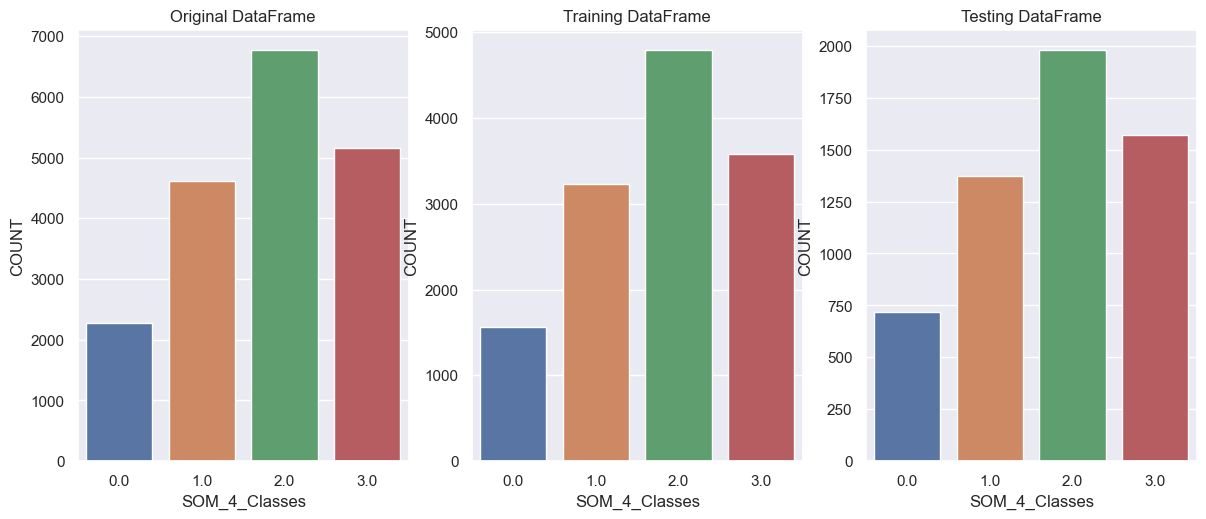

In [25]:
Graficar_Set(df_Categories_original,df_Categories_Train,df_Categories_Test,'SOM_4_Classes'); plt.show()

## Modelo de clasificacion (Support Vector Machine).

Para la construcción del modelo clasificador se empleó la biblioteca de SciKit Learn, la cual proporciona las herramientas para entrenar un modelo de tipo Support Vector Machine. Para este caso se utilizó el set de datos obtenido a partir de los datos de registros geofísicos de pozo estandarizados. Considerando las clases desbalanceadas se incluyeron pesos al proceso de entrenamiento mediante el argumento "class_weight" el cual toma las proporciones de las clases para colocar pesos y favorecer ciertas clases, en este caso las que menos muestras tienen, durante la clasificación.

In [26]:
start_time = time.time()
svm_model = SVC(kernel='rbf', probability=True, decision_function_shape='ovo', class_weight='balanced')
svm_model.fit(X_Train, Y_Train)
print('SVM score de entrenamiento: ', svm_model.score(X_Train, Y_Train))
finish_time = time.time(); tiempo_entrenamiento_SVM = finish_time - start_time
print('Training time', tiempo_entrenamiento_SVM, 'seconds') 

SVM score de entrenamiento:  0.7997265892002734
Training time 27.81073236465454 seconds


### Metricas en el set de entrenamiento.

Una vez entrenado el modelo, se procedio a relaizar la evaluacion del desempeño del mismo mediante la prediccion de clases en datos del mismo set de entrenamiento.

In [27]:
predicted_svm = pd.DataFrame(svm_model.predict(X_Train), columns=['Y_Predicted'])
probs_svm = pd.DataFrame(svm_model.predict_proba(X_Train))

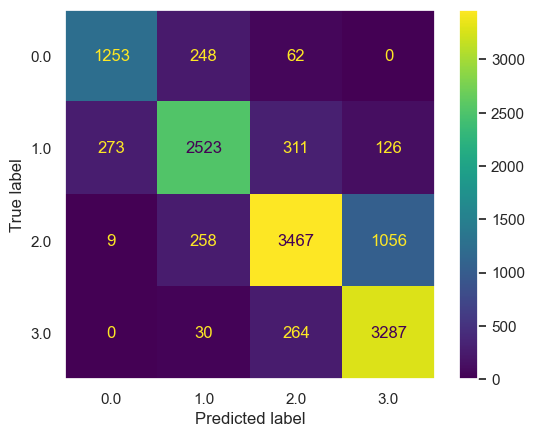

In [28]:
svm_ConfusionMatrix = metrics.confusion_matrix(Y_Train, predicted_svm.to_numpy())
disp = metrics.ConfusionMatrixDisplay(svm_ConfusionMatrix, display_labels=svm_model.classes_)
disp.plot(); plt.grid(visible=False); plt.show()

In [29]:
svm_accuracy = metrics.accuracy_score(Y_Train, predicted_svm)
svm_roc_auc = metrics.roc_auc_score(Y_Train, probs_svm.to_numpy(), multi_class='ovo')
svm_confus_matrix = metrics.confusion_matrix(Y_Train, predicted_svm)
svm_classification_report = metrics.classification_report(Y_Train, predicted_svm, zero_division=1)
svm_precision = metrics.precision_score(Y_Train, predicted_svm, pos_label=1, average='macro', zero_division=0)
svm_recall = metrics.recall_score(Y_Train, predicted_svm, pos_label=1, average='macro', zero_division=0)
svm_f1 = metrics.f1_score(Y_Train, predicted_svm, pos_label=1, average='macro', zero_division=0)

### Metricas en el set de validacion.

In [30]:
predicted_svm1 = pd.DataFrame(svm_model.predict(X_Test), columns=['Y_Predicted'])
probs_svm1 = pd.DataFrame(svm_model.predict_proba(X_Test))

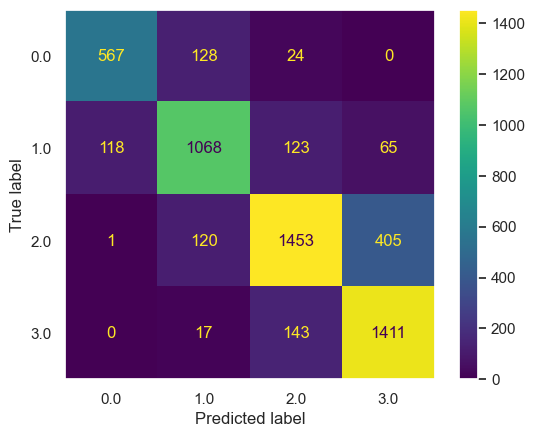

In [31]:
svm_ConfusionMatrix1 = metrics.confusion_matrix(Y_Test, predicted_svm1.to_numpy())
disp1 = metrics.ConfusionMatrixDisplay(svm_ConfusionMatrix1, display_labels=svm_model.classes_)
disp1.plot(); plt.grid(visible=False); plt.show()

In [32]:
svm_accuracy1 = metrics.accuracy_score(Y_Test, predicted_svm1)
svm_roc_auc1 = metrics.roc_auc_score(Y_Test, probs_svm1.to_numpy(), multi_class='ovo')
svm_precision1 = metrics.precision_score(Y_Test, predicted_svm1, pos_label=1, average='macro', zero_division=0)
svm_recall1 = metrics.recall_score(Y_Test, predicted_svm1, pos_label=1, average='macro', zero_division=0)
svm_f11 = metrics.f1_score(Y_Test, predicted_svm1, pos_label=1, average='macro', zero_division=0)

In [33]:
models = pd.DataFrame({'Model':['Support Vector Machine Train', 'Support Vector Machine Test'],'Accuracy'
                       :[svm_accuracy,svm_accuracy1],'Precision':[svm_precision,svm_precision1],
                       'recall':[svm_recall,svm_recall1],'F1':[svm_f1,svm_f11],'AUC ROC':[svm_roc_auc,svm_roc_auc1]})
models.sort_values(by='F1', ascending=False)

,Model,Accuracy,Precision,recall,F1,AUC ROC
0,Support Vector Machine Train,0.799727,0.805341,0.805938,0.801788,0.959216
1,Support Vector Machine Test,0.797271,0.802871,0.799563,0.798611,0.956666


## Modelo de Clasificación (Support Vector Machine PCA).

In [34]:
start_time = time.time()
svm_model_pca = SVC(kernel='rbf', degree=3, probability=True, decision_function_shape='ovo')    
svm_model_pca.fit(X_Train_pca, Y_Train_pca)
print('SVM score de entrenamiento: ', svm_model_pca.score(X_Train_pca, Y_Train_pca))
finish_time = time.time(); tiempo_entrenamiento_SVM_PCA = finish_time - start_time
print('Training time', tiempo_entrenamiento_SVM_PCA, 'seconds') 

SVM score de entrenamiento:  0.7969924812030075
El tiempo que tarda entrenar es de  28.116390705108643 segundos


### Metricas en el set de entrenamiento.

In [35]:
predicted_svm_pca = pd.DataFrame(svm_model_pca.predict(X_Train_pca), columns=['Y_Predicted'])
probs_svm_pca = pd.DataFrame(svm_model_pca.predict_proba(X_Train_pca))

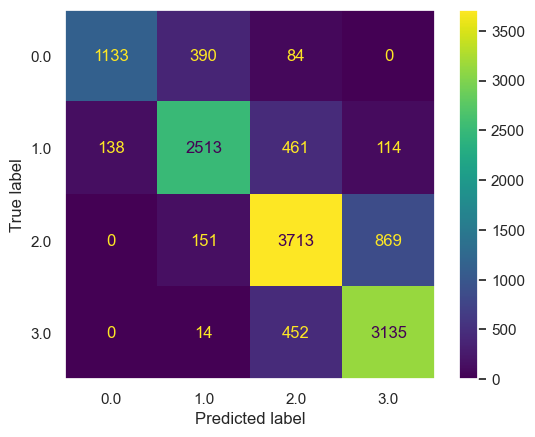

In [36]:
svm_pca_ConfusionMatrix = metrics.confusion_matrix(Y_Train_pca, predicted_svm_pca.to_numpy())
disp = metrics.ConfusionMatrixDisplay(svm_pca_ConfusionMatrix, display_labels=svm_model_pca.classes_)
disp.plot(); plt.grid(visible=False); plt.show()

In [37]:
svm_pca_accuracy = metrics.accuracy_score(Y_Train_pca, predicted_svm_pca)
svm_pca_roc_auc = metrics.roc_auc_score(Y_Train_pca, probs_svm_pca.to_numpy(), multi_class='ovo')
svm_pca_confus_matrix = metrics.confusion_matrix(Y_Train_pca, predicted_svm_pca)
svm_pca_classification_report = metrics.classification_report(Y_Train_pca, predicted_svm_pca, zero_division=1)
svm_pca_precision = metrics.precision_score(Y_Train_pca, predicted_svm_pca, pos_label=1, average='macro', zero_division=0)
svm_pca_recall = metrics.recall_score(Y_Train_pca, predicted_svm_pca, pos_label=1, average='macro', zero_division=0)
svm_pca_f1 = metrics.f1_score(Y_Train_pca, predicted_svm_pca, pos_label=1, average='macro', zero_division=0)

### Metricas en el set de Validacion.

In [38]:
predicted_svm1_pca = pd.DataFrame(svm_model_pca.predict(X_Test_pca), columns=['Y_Predicted'])
probs_svm1_pca = pd.DataFrame(svm_model_pca.predict_proba(X_Test_pca))

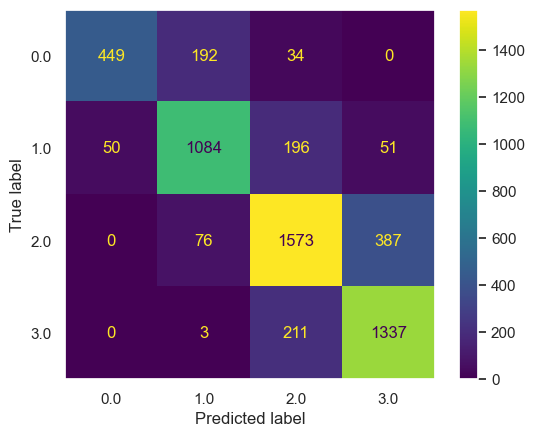

In [39]:
svm_pca_ConfusionMatrix1 = metrics.confusion_matrix(Y_Test_pca, predicted_svm1_pca.to_numpy())
disp1 = metrics.ConfusionMatrixDisplay(svm_pca_ConfusionMatrix1, display_labels=svm_model_pca.classes_)
disp1.plot(); plt.grid(visible=False); plt.show()

In [40]:
svm_pca_accuracy1 = metrics.accuracy_score(Y_Test_pca, predicted_svm1_pca)
svm_pca_roc_auc1 = metrics.roc_auc_score(Y_Test_pca, probs_svm1_pca.to_numpy(), multi_class='ovo')
svm_pca_precision1 = metrics.precision_score(Y_Test_pca, predicted_svm1_pca, pos_label=1, average='macro', zero_division=0)
svm_pca_recall1 = metrics.recall_score(Y_Test_pca, predicted_svm1_pca, pos_label=1, average='macro', zero_division=0)
svm_pca_f11 = metrics.f1_score(Y_Test_pca, predicted_svm1_pca, pos_label=1, average='macro', zero_division=0)

In [41]:
models_pca = pd.DataFrame({'Model':['Support Vector Machine (PCA) Train', 'Support Vector Machine (PCA) Test'],'Accuracy'
                       :[svm_pca_accuracy,svm_pca_accuracy1],'Precision':[svm_pca_precision,svm_pca_precision1],
                       'recall':[svm_pca_recall,svm_pca_recall1],'F1':[svm_pca_f1,svm_pca_f11],
                       'AUC ROC':[svm_pca_roc_auc,svm_pca_roc_auc1]})
models_pca.sort_values(by='F1', ascending=False)

,Model,Accuracy,Precision,recall,F1,AUC ROC
0,Support Vector Machine (PCA) Train,0.796992,0.815035,0.784777,0.796144,0.953425
1,Support Vector Machine (PCA) Test,0.787347,0.808518,0.771185,0.784516,0.949141


## Selección del mejor modelo.

Una vez entrenados los distintos modelos se agruparon las métricas de los mismos en una sola tabla para facilitar la selección del modelo optimo, asimismo se incluye un pequeño apartado con un comparativo del tiempo de entrenamiento de cada uno.

In [42]:
df_metricas = pd.concat([models,models_pca], axis=0, ignore_index=True)
df_metricas

,Model,Accuracy,Precision,recall,F1,AUC ROC
0,Support Vector Machine Train,0.799727,0.805341,0.805938,0.801788,0.959216
1,Support Vector Machine Test,0.797271,0.802871,0.799563,0.798611,0.956666
2,Support Vector Machine (PCA) Train,0.796992,0.815035,0.784777,0.796144,0.953425
3,Support Vector Machine (PCA) Test,0.787347,0.808518,0.771185,0.784516,0.949141


In [43]:
df_tiempo_entrenamiento = pd.DataFrame({'Support Vector Machine':tiempo_entrenamiento_SVM,
                                        'Support Vector Machine (PCA)':tiempo_entrenamiento_SVM_PCA},index=[0])
df_tiempo_entrenamiento

,Support Vector Machine,Support Vector Machine (PCA)
0,27.810732,28.116391
